# Table of contents

1. **Minimal approach:** how to run the code to read the DFT data, define the optimal model, and calculate the model coefficients.
2. **Plot results:** how to read the code results and plot the bands.
3. **Verify set alpha:** alternative code to verify if the selection is correct.
4. **Verify convergence:** check how the coefficients change with the number of remote bands.

# Minimal approach

In this first section we run the minimal code as shown in the paper. 

**How to select set alpha?**

Here we avoid plotting figures to keep the code simple. So, to properly identify the set A (alpha), the user must plot the bands separatelly (via xmgrace, for instance) and identify the index of the relevant bands.

Alternativelly, the user can replace *step 3* with a more elaborated code shown in the section **Verify set alpha** below.

In [1]:
import numpy as np
import pydft2kp as dft2kp

In [3]:
%%capture
# avoid unecessary output from the irrep package

# step 1: read DFT data
kp = dft2kp.irrep(dftdir='Bi2Se3',
                  outdir='outdir',
                  prefix='Bi2Se3',
                  kpt=31,
                  kname='GM')

# step 2: read or calculate matrix elements of p
kp.get_p_matrices(qekp='kp.dat')

In [4]:
# step 3: define the set alpha
#         applies fold down via Löwdin
setA = np.arange(76,80)
kp.define_set_A(setA)

Space group  166 : R-3m
Group of the k-vector: <code not ready>
Verifying set A: [76 77 78 79]
Band indices: [76, 77] Irreps: (-GM8) Degeneracy: 2
Band indices: [78, 79] Irreps: (-GM9) Degeneracy: 2


In [5]:
# step 4: builds optimal model with qsymm
# s0, sx, sy, sz: Pauli matrices
from pydft2kp.constants import s0, sx, sy, sz
from scipy.linalg import expm

# build symmetry operations of D3d = {Inv, C2x, C3z}
# consider also additional symmetry RT = time-reversal x inversion

R1 = 0.5
R3 = np.sqrt(3)/2

# Inversão:
orb  = +sz
spin = +s0
pU = np.kron(spin, orb)                              # wave-function basis            
pR = np.array([[-1, 0, 0], [0, -1, 0], [0, 0, -1]])  # k-basis
Inv = dft2kp.PointGroupElement(pR, False, False, pU)

# C2x:
orb  = +sz
spin = -1j*sx
pU = np.kron(spin, orb)                              # wave-function basis            
pR = np.array([[+1, 0, 0], [0, -1, 0], [0, 0, -1]])  # k-basis
C2x = dft2kp.PointGroupElement(pR, False, False, pU)

# C3z:
phi = (np.pi)/3
orb = +s0
spin = np.array([[np.exp(-1j*phi), 0],[0, np.exp(+1j*phi)]])
pU = np.kron(spin, orb)                                    # wave-function basis            
pR = np.array([[-R1, -R3, 0], [+R3, -R1, 0], [0, 0, +1]])  # k-basis
C3z = dft2kp.PointGroupElement(pR, False, False, pU)

# TRS:
orb = +s0
spin = +1j*sy
pU = np.kron(spin, orb)
TRS = dft2kp.time_reversal(3, U = pU)

symms = [Inv, C2x, C3z, TRS]
qs = dft2kp.qsymm(symms, dim=3, total_power=2, prettify=True, print_model=True, summed=True);

Matrix([
[c0 + c4*k_x**2 + c4*k_y**2 + c6*k_z**2,                               I*c3*k_z,                                      0,                      I*c2*k_x + c2*k_y],
[                             -I*c3*k_z, c1 + c5*k_x**2 + c5*k_y**2 + c7*k_z**2,                      I*c2*k_x + c2*k_y,                                      0],
[                                     0,                     -I*c2*k_x + c2*k_y, c0 + c4*k_x**2 + c4*k_y**2 + c6*k_z**2,                               I*c3*k_z],
[                    -I*c2*k_x + c2*k_y,                                      0,                              -I*c3*k_z, c1 + c5*k_x**2 + c5*k_y**2 + c7*k_z**2]])

In [6]:
# step 5: calculate the representation matrices for each symmetry operation
kp.get_symm_matrices()
# (optional): adds anti-unitary symmetry
kp.add_antiunitary_symm(TRS, np.array([0,0,0]))

# step 6: calculates and applies the transformation U
optimal = dft2kp.basis_transform(qs, kp)

# step 7: print results
optimal.print_report(sigdigits=3)

cn      a.u. (Ry, a0)    with (eV, nm)  units    k powers
----  ---------------  ---------------  -------  ----------
c0            -0.0221          -0.301   eV       0
c1             0.0199           0.271   eV       0
c2             0.382            0.275   eV.nm    x,y
c3             0.248            0.179   eV.nm    z
c4             9.45             0.36    eV.nm²   xx,yy
c5            -4.36            -0.166   eV.nm²   xx,yy
c6             1.54             0.0586  eV.nm²   zz
c7            -1.22            -0.0467  eV.nm²   zz


# Plot results

Once the model is complete, we can plot the bands.

Here the `qe_plotter(...)` is a helper to read the DFT bands in gnuplot format and organize the data to be plotted in python. It provides

- a helper routine `set_labels_and_limits(...)` to fix plot labels and k axis
- kdist: 1D array for the axis points properly spaced
- k3D: list of (kx,ky,kz) for each point in kdist

In [7]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

# kpath as run in the bands calculation of QE
kpath = [[    30,          30,      1], 
         [R'$F$', R'$\Gamma$', R'$L$']]

# init plotter
bands = dft2kp.qe_plotter(kp, 'bands.gnu', kpath)

In [8]:
# crude and optimal models as H(kx,ky,kz)

# build crude model with all bands
H_crude_full = kp.build_H_of_k(all_bands=True)
# build crude model folded into set A
H_crude_setA = kp.build_H_of_k(all_bands=False)

# the optimal model for set was already computed
# in step 6 above: optimal.Heff

# compute the eigenenergies as a function k for the path used in QE's data
Efull = np.array([np.linalg.eigvalsh(H_crude_full(*kvec)) for kvec in bands.k3D])
EsetA = np.array([np.linalg.eigvalsh(H_crude_setA(*kvec)) for kvec in bands.k3D])
Ek = np.array([np.linalg.eigvalsh(optimal.Heff(*kvec)) for kvec in bands.k3D])

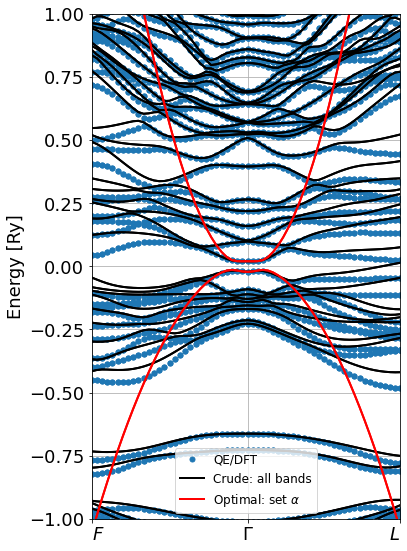

In [9]:
plt.figure(figsize=(6,8))
pdft   = plt.plot(bands.kdist, bands.bands, 'o', c='C0', ms=5) 
pcrude = plt.plot(bands.kdist, Efull, c='black', lw=2)
poptim = plt.plot(bands.kdist, Ek, c='red', lw=2)
# set legends for single lines
pdft[0].set_label('QE/DFT')
pcrude[0].set_label('Crude: all bands')
poptim[0].set_label(r'Optimal: set $\alpha$')
plt.legend(fontsize=12)
bands.set_labels_and_limits(ax=plt.gca(), ymin=-1, ymax=1)
plt.grid()

plt.tight_layout()
basename = 'Figures/' + kp.dftdir.replace('/', '')
plt.savefig(basename + '.svg')
plt.savefig(basename + '.png')
plt.show()

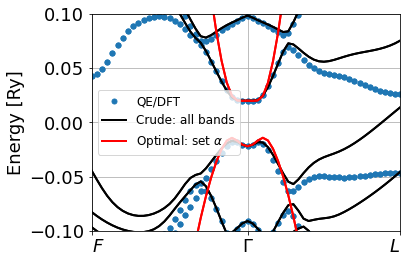

In [10]:
##############################################################
# ZOOM IN
##############################################################

plt.figure(figsize=(6,4))
pdft   = plt.plot(bands.kdist, bands.bands, 'o', c='C0', ms=5) 
pcrude = plt.plot(bands.kdist, Efull, c='black', lw=2)
poptim = plt.plot(bands.kdist, Ek, c='red', lw=2)
# set legends for single lines
pdft[0].set_label('QE/DFT')
pcrude[0].set_label('Crude: all bands')
poptim[0].set_label(r'Optimal: set $\alpha$')
plt.legend(fontsize=12)
bands.set_labels_and_limits(ax=plt.gca(), ymin=-0.1, ymax=0.1)#, xmin=-3*dft2kp.a0, xmax=3*dft2kp.a0)
plt.grid()

plt.tight_layout()
basename = 'Figures/' + kp.dftdir.replace('/', '')
plt.savefig(basename + '-zoom.svg')
plt.savefig(basename + '-zoom.png')
plt.show()

# Verify set alpha

If the user wants to verify if set A (alpha) was chosen correctly, it is useful to plot the DFT bands emphasizing the set A.

In this case, add this steps to step 3 above:

1. Init matplotlib and plotter if necessary. See Plot results section above.
2. Plot the bands and set follwing this example:

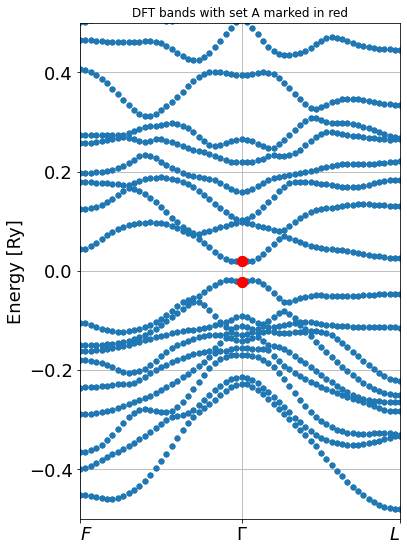

In [11]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(6,8))
plt.title('DFT bands with set A marked in red', fontsize=12)
plt.plot(bands.kdist, bands.bands, 'o', ms=5, c='C0') # DFT
# ----------------------
# Emphasize set A in red
plt.scatter([0]*len(setA), bands.en_at_k[setA], c='red', s=100, zorder=10)
# ----------------------
bands.set_labels_and_limits(ax=plt.gca(), ymin=-1/2, ymax=1/2)
plt.grid()
plt.tight_layout()
plt.show()

# Verify convergence

To verify the convergence of the parameter as a function of the number of bands, one can redo the folding down with a reduced number of remote bands and plot how the coefficients change as a function of the number of remote bands.

In [12]:
nbands = len(kp.energies)
NBs = np.arange(0, nbands - setA[-1], 5)
cns = []
for NB in NBs:
    # redo fold down using only NB remote bands
    kp.fold_down_H(NB=NB)
    # identify and store list of coefficients
    cns += [list(optimal.getHeff(qs, kp)[0])]
cns = np.array(cns)

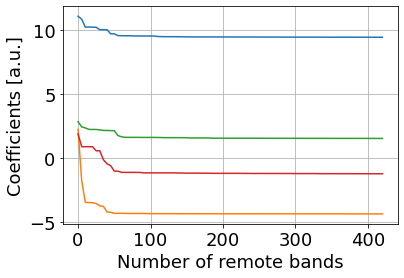

In [13]:
for n in range(cns.shape[1]):
    # only k² or larger powers depend on number of remote bands
    if set(optimal.keys[n]) & set([0, 'x','y','z']):
        continue
    plt.plot(NBs, cns[:,n], label=optimal.keys[n])
# plt.legend(fontsize=10)
plt.xlabel('Number of remote bands')
plt.ylabel(r'Coefficients [a.u.]')
plt.grid()
plt.show()